In [1]:
# Import GoldUtilities
push!(LOAD_PATH, joinpath(@__DIR__, "..", "scripts"))
using GoldUtilities
import GoldUtilities.Loader as loader

In [2]:
# Add the MSSim package
using MSSim
const Opts = MSSim.Optimizers
const SS = MSSim.SegSeq
const SL = MSSim.SymLinear
const Seq = MSSim.Sequence

MSSim.Sequence

In [3]:
using BenchmarkTools
using NLopt
using Statistics
using PyPlot
using JSON
ENV["MPLBACKEND"] = "module://matplotlib_inline.backend_inline"

"module://matplotlib_inline.backend_inline"

In [4]:
sysparams = loader.GoldParams("../system params/072125_goldparams_13ions.json")

GoldUtilities.Loader.GoldParams([2.29049, 2.31223, 2.33447, 2.3566, 2.37964, 2.40187, 2.42345, 2.44437, 2.46325, 2.48068, 2.49643, 2.50981, 2.51649], [0.12582898125060124, 0.1254757153730443, 0.1250569316248486, 0.12461075061627393, 0.12415467122300929, 0.12370104825133979, 0.12325955010900741, 0.12283842408236283, 0.12244532009242795, 0.12208804746084248, 0.12177563418463196, 0.12151470773707744, 0.1213753723354335], [0.002163619698947626 -0.019894333993010195 … -0.019894333993005258 0.0021636196989478743; 0.0071396181636678106 -0.05753283102846898 … 0.05753283102846495 -0.007139618163669534; … ; 0.42615110225953595 0.36754442103650975 … -0.36754442103645346 -0.4261511022594881; 0.2773500981126128 0.2773500981125969 … 0.27735009811265454 0.27735009811265965], Dict("x1" => 0.0, "x4" => 0.00131, "x2" => 0.0124, "qzy" => 0.12, "dy" => 71.0, "qzz" => 0.85, "x3" => 0.0))

In [5]:
# Construct modes matrtix using system parameters
const modes = Seq.Modes()
const ion1 = 5
const ion2 = 9
for i in 1:13
    push!(modes, 2π * sysparams.radial_modes[i], sysparams.participation_factors[i, ion1] * sysparams.participation_factors[i, ion2] * sysparams.etas[i]^2)
end

In [6]:
# Function to give a balckman amplitude profile
function blackman_start_end(x)
    if -0.5 <= x <= 0.5
        return 1.0
    elseif x < 0
        x = (x + 0.5) * 2
    else
        x = (x - 0.5) * 2
    end
    return 0.42 + 0.5 * cospi(x) + 0.08 * cospi(2 * x)
end

blackman_start_end (generic function with 1 method)

In [7]:
const nseg = 120
const buf_opt = SL.ComputeBuffer{nseg,Float64}(Val(SS.mask_allδ), Val(SS.mask_allδ));
const buf_plot = SL.ComputeBuffer{nseg,Float64}(Val(SS.mask_full), Val(SS.mask_full));

In [8]:
function _objfunc(vals)
    dis = vals[1]
    disδ = vals[2]
    area = vals[3]
    areaδ = vals[4]
    τ = vals[5]

    return 5 * dis + disδ / 100 + (abs(area) - π / 2)^2 * 100 + (areaδ / 1e4)^2
end
const objfunc = Opts.autodiff(_objfunc);

In [9]:
const nlmodel = Seq.Objective(SL.pmask_full,
                              ((:dis2, 0), (:disδ2, 0), (:area, 0),
                               (:areaδ, 0), (:τ, 0)),
                              objfunc, modes, buf_opt,
                              freq=Seq.FreqSpec(true, sym=false),
                              amp=Seq.AmpSpec(cb=blackman_start_end));

In [10]:
pitime_to_Ω(time) = π / (2 * time)
const nargs = Seq.nparams(nlmodel)
const tracker = Opts.NLVarTracker(nargs)
Opts.set_bound!(tracker, nlmodel.param.τ, 0.1, 2.5)
Opts.set_bound!(tracker, nlmodel.param.Ωs[1], pitime_to_Ω(8), pitime_to_Ω(3.8))
for ω in nlmodel.param.ωs
    Opts.set_bound!(tracker, ω, 2π * 2.29, 2π * 2.50)
end

In [11]:
# const opt = NLopt.Opt(:LD_SLSQP, nargs)
const opt = NLopt.Opt(:LD_LBFGS, nargs)
# NLopt.xtol_rel!(opt, 1e-5)
# NLopt.ftol_rel!(opt, 1e-5)
NLopt.min_objective!(opt, nlmodel)
NLopt.lower_bounds!(opt, Opts.lower_bounds(tracker))
NLopt.upper_bounds!(opt, Opts.upper_bounds(tracker))
NLopt.maxtime!(opt, 10)

In [12]:
best_obj = 100.0
best_params = nothing
@time for i in 1:50
    global best_obj, best_params
    obj, params, ret = @time NLopt.optimize(opt, Opts.init_vars!(tracker))
    if getfield(NLopt, ret) < 0
        continue
    end
    if obj < best_obj
        best_obj = obj
        area = nlmodel(Val((:area, 0)), params)
        best_status = (
            obj = obj,
            dis = nlmodel(Val((:dis2, 0)), params),
            disδ = nlmodel(Val((:disδ2, 0)), params),
            area = area,
            areaε = abs(area) - π / 2,
            areaδ = nlmodel(Val((:areaδ, 0)), params),
            total_t = nlmodel(Val((:τ, 0)), params),
            Ωmax = params[nlmodel.param.Ωs[1]],
        )
        println(best_status)
        best_params = params
    end
end

  2.328387 seconds (2.73 M allocations: 135.755 MiB, 4.96% gc time, 97.94% compilation time)
  2.175266 seconds (60.05 k allocations: 3.094 MiB)
  2.236090 seconds (59.66 k allocations: 3.074 MiB)
 10.000195 seconds (237.55 k allocations: 12.235 MiB)
(obj = 2.342493333644353e-5, dis = 4.543924625644285e-13, disδ = 4.526718194993886e-12, area = 1.5707961777992434, areaε = -1.489956531486314e-7, areaδ = -48.39930660582191, total_t = 283.5165012443237, Ωmax = 0.4131730639711872)
  1.279919 seconds (30.72 k allocations: 1.584 MiB)
  4.078355 seconds (111.71 k allocations: 5.755 MiB)
  0.043070 seconds (1.22 k allocations: 66.156 KiB)
 10.000883 seconds (253.82 k allocations: 13.073 MiB)
  8.037673 seconds (203.76 k allocations: 10.495 MiB)
  0.053966 seconds (1.36 k allocations: 73.750 KiB)
  3.834911 seconds (92.49 k allocations: 4.765 MiB)
  1.476516 seconds (26.40 k allocations: 1.362 MiB)
  0.057200 seconds (1.18 k allocations: 64.047 KiB)
 10.000245 seconds (272.79 k allocations: 14.0

In [13]:
opt_raw_params = Seq.RawParams(nlmodel, best_params)
println(opt_raw_params)

MSSim.Sequence.RawParams([2.3777495455902824, -5.7366258190931444e-18, 0.00017225928251361124, 0.0, 15.196206918805139, 2.3777495455902824, 0.00040958943072044143, 0.0005248434901922211, 36.13277409588483, 14.481992403842467, 2.3777495455902824, 0.001657535801031013, 0.0009011012652206336, 70.56732495336317, 15.579330504921273, 2.3777495455902824, 0.003800128924940203, 0.0013150951957585102, 107.61107098204056, 14.820301966439704, 2.3777495455902824, 0.006927095929062964, 0.0017783936913197637, 142.85003724825333, 14.948189502003856, 2.3777495455902824, 0.011155670720479157, 0.002299240405443761, 178.39308804404044, 14.795754956425185, 2.3777495455902824, 0.016622688549725876, 0.0028818817839346726, 213.5736876683456, 15.090859309256887, 2.3777495455902824, 0.023475081651921456, 0.0035260855481765475, 249.45597153349803, 15.042096556576244, 2.3777495455902824, 0.0318592299618107, 0.004226874400349408, 285.2223097856223, 14.955412517342598, 2.3777495455902824, 0.041909678646508707, 0.00

In [14]:
kern = SL.Kernel(buf_plot, Val(SL.pmask_full));

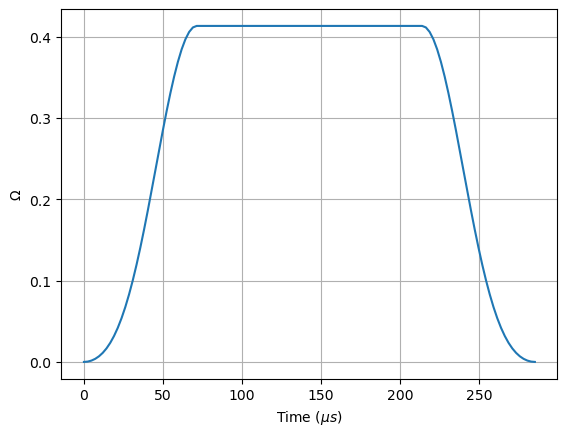

In [15]:
clf()
plot(Seq.get_Ωs(opt_raw_params)...)
xlabel(raw"Time ($\mu s$)")
ylabel(raw"$\Omega$")
grid()
display(gcf())

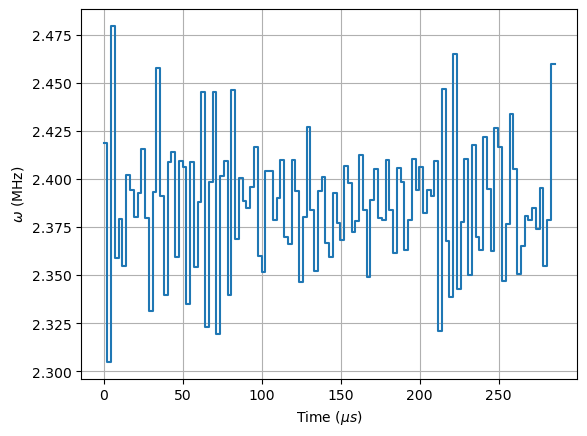

In [16]:
clf()
ts, ωs = Seq.get_ωs(opt_raw_params)
plot(ts, ωs ./ 2π)
xlabel(raw"Time ($\mu s$)")
ylabel(raw"$\omega$ (MHz)")
grid()
display(gcf())

In [17]:
println("Total displacement:")
println(Seq.total_dis(kern, opt_raw_params, modes))
println("cumulative displacement:")
println(Seq.total_cumdis(kern, opt_raw_params, modes))
println("Gradient of displacement w.r.t. detuning (disδ)")
println(Seq.total_disδ(kern, opt_raw_params, modes))
println("Enclosed area (area)")
println(Seq.total_area(kern, opt_raw_params, modes))
println("Gradient of enclosed area w.r.t. detuning (areaδ)")
println(Seq.total_areaδ(kern, opt_raw_params, modes))

Total displacement:
2.613062397321329e-12
cumulative displacement:
2.1820492851290967e-7
Gradient of displacement w.r.t. detuning (disδ)
4.788418483528928e-11
Enclosed area (area)
1.5707961274206566
Gradient of enclosed area w.r.t. detuning (areaδ)
-47.771152041879056


In [18]:
plot_δs = range(-1, 1, 10001); # kHz

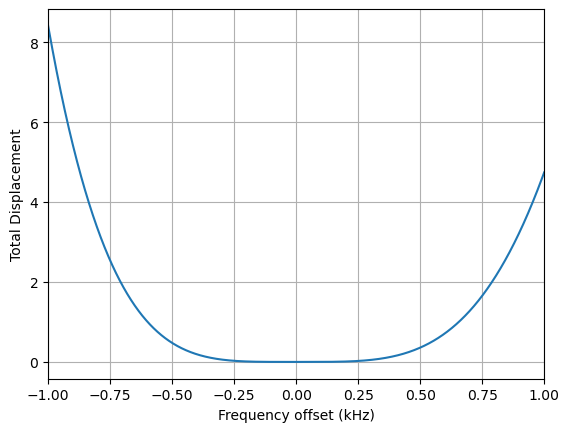

In [19]:
clf()
plot(plot_δs, [Seq.total_dis(kern, Seq.adjust(opt_raw_params, δ=2π * δ / 1000), modes) for δ in plot_δs])
xlim([-1, 1])
# ylim([0, 100])
xlabel("Frequency offset (kHz)")
ylabel("Total Displacement")
grid()
display(gcf())

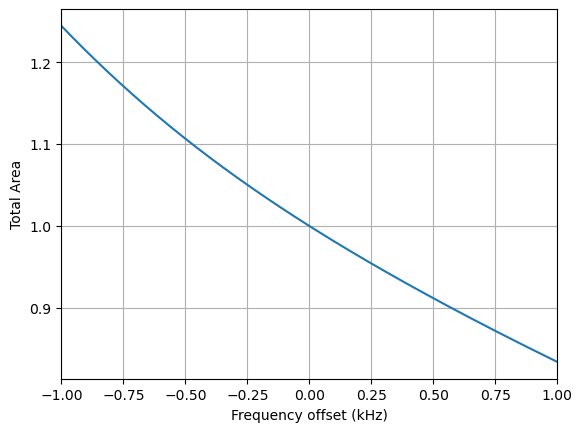

In [20]:
clf()
area0 = Seq.total_area(kern, opt_raw_params, modes)
plot(plot_δs, [Seq.total_area(kern, Seq.adjust(opt_raw_params, δ=2π * δ / 1000), modes) / area0 for δ in plot_δs])
xlim([-1, 1])
xlabel("Frequency offset (kHz)")
ylabel("Total Area")
grid()
display(gcf())

In [ ]:
gate_info = Seq.gate_solution_info(opt_raw_params)
gate_info["angle_sign"] = 1
solution = Dict(
    "XX" => Dict(
        "2,-2" => gate_info
    ),
    "modes"=> Dict(
        "radial" => sysparams.radial_modes * 1e6
    )
)
open("../out/20250722_linear_pm_13_v2.json", "w") do f
    JSON.print(f, solution, 2)
end